In [ ]:
!unzip /content/drive/MyDrive/aquaium_pritrain_coco.zip

Archive:  /content/drive/MyDrive/aquaium_pritrain_coco.zip
   creating: aquaium_pritrain_coco/
  inflating: aquaium_pritrain_coco/README.dataset.txt  
  inflating: aquaium_pritrain_coco/README.roboflow.txt  
   creating: aquaium_pritrain_coco/test/
  inflating: aquaium_pritrain_coco/test/IMG_2289_jpeg_jpg.rf.397637b34be1d562b746c9f17965c3b5.jpg  
  inflating: aquaium_pritrain_coco/test/IMG_2301_jpeg_jpg.rf.2c03f6b4ed591be02920ea00dec9e0ec.jpg  
  inflating: aquaium_pritrain_coco/test/IMG_2319_jpeg_jpg.rf.32a52cbd9a504f433729fc3a21834c07.jpg  
  inflating: aquaium_pritrain_coco/test/IMG_2347_jpeg_jpg.rf.e513e361963ca419d869506bec76ccb5.jpg  
  inflating: aquaium_pritrain_coco/test/IMG_2354_jpeg_jpg.rf.94942d7226c7bcab04eb98ade93b34d7.jpg  
  inflating: aquaium_pritrain_coco/test/IMG_2371_jpeg_jpg.rf.a66b0f882b01eef67b181840b078e9e1.jpg  
  inflating: aquaium_pritrain_coco/test/IMG_2379_jpeg_jpg.rf.e0a0a3fdeb739021688a0867948a307f.jpg  
  inflating: aquaium_pritrain_coco/test/IMG_2380_jp

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
!pip install -U torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinu

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.2.2+cu121
0.17.2+cu121


In [ ]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools

In [ ]:
from pycocotools.coco import COCO

In [ ]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/aquaium_pritrain_coco"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{0: {'id': 0, 'name': 'f-ccdF', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'f-ccdF'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'f-ccdF'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'f-ccdF'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'f-ccdF'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'f-ccdF'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'f-ccdF'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'f-ccdF'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['f-ccdF',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [ ]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


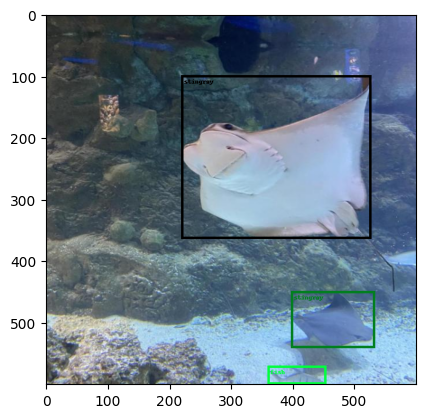

In [ ]:
# Lets view a sample
sample = train_dataset[40]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

447

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:04<00:00, 15.6MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device("cuda") # use GPU to train

In [ ]:
model = model.to(device)

In [ ]:
torch.cuda.current_device()

0

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
import sys

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=100

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 112/112 [00:22<00:00,  5.00it/s]


Epoch 0, lr: 0.010000, loss: 0.981261, loss_classifier: 0.462688, loss_box: 0.390726, loss_rpn_box: 0.033094, loss_object: 0.094752


100%|██████████| 112/112 [00:20<00:00,  5.53it/s]


Epoch 1, lr: 0.010000, loss: 0.787227, loss_classifier: 0.357374, loss_box: 0.338212, loss_rpn_box: 0.028153, loss_object: 0.063488


100%|██████████| 112/112 [00:21<00:00,  5.22it/s]


Epoch 2, lr: 0.010000, loss: 0.727310, loss_classifier: 0.312574, loss_box: 0.340362, loss_rpn_box: 0.026940, loss_object: 0.047433


100%|██████████| 112/112 [00:20<00:00,  5.39it/s]


Epoch 3, lr: 0.010000, loss: 0.684736, loss_classifier: 0.272459, loss_box: 0.345544, loss_rpn_box: 0.025454, loss_object: 0.041279


100%|██████████| 112/112 [00:19<00:00,  5.62it/s]


Epoch 4, lr: 0.010000, loss: 0.659343, loss_classifier: 0.256378, loss_box: 0.341629, loss_rpn_box: 0.023566, loss_object: 0.037769


100%|██████████| 112/112 [00:19<00:00,  5.68it/s]


Epoch 5, lr: 0.010000, loss: 0.631741, loss_classifier: 0.247774, loss_box: 0.326818, loss_rpn_box: 0.022951, loss_object: 0.034198


100%|██████████| 112/112 [00:18<00:00,  5.92it/s]


Epoch 6, lr: 0.010000, loss: 0.642130, loss_classifier: 0.239411, loss_box: 0.347514, loss_rpn_box: 0.022903, loss_object: 0.032302


100%|██████████| 112/112 [00:19<00:00,  5.86it/s]


Epoch 7, lr: 0.010000, loss: 0.628043, loss_classifier: 0.227677, loss_box: 0.349004, loss_rpn_box: 0.022110, loss_object: 0.029252


100%|██████████| 112/112 [00:18<00:00,  6.03it/s]


Epoch 8, lr: 0.010000, loss: 0.615884, loss_classifier: 0.223038, loss_box: 0.344300, loss_rpn_box: 0.021108, loss_object: 0.027437


100%|██████████| 112/112 [00:19<00:00,  5.78it/s]


Epoch 9, lr: 0.010000, loss: 0.624234, loss_classifier: 0.229580, loss_box: 0.346752, loss_rpn_box: 0.021105, loss_object: 0.026797


100%|██████████| 112/112 [00:18<00:00,  6.01it/s]


Epoch 10, lr: 0.010000, loss: 0.611256, loss_classifier: 0.226462, loss_box: 0.340370, loss_rpn_box: 0.020679, loss_object: 0.023745


100%|██████████| 112/112 [00:18<00:00,  6.15it/s]


Epoch 11, lr: 0.010000, loss: 0.613695, loss_classifier: 0.222230, loss_box: 0.349482, loss_rpn_box: 0.019840, loss_object: 0.022143


100%|██████████| 112/112 [00:18<00:00,  6.14it/s]


Epoch 12, lr: 0.010000, loss: 0.594254, loss_classifier: 0.211242, loss_box: 0.341386, loss_rpn_box: 0.019420, loss_object: 0.022206


100%|██████████| 112/112 [00:18<00:00,  5.94it/s]


Epoch 13, lr: 0.010000, loss: 0.584677, loss_classifier: 0.204310, loss_box: 0.336411, loss_rpn_box: 0.019737, loss_object: 0.024219


100%|██████████| 112/112 [00:18<00:00,  6.15it/s]


Epoch 14, lr: 0.010000, loss: 0.611470, loss_classifier: 0.218074, loss_box: 0.352596, loss_rpn_box: 0.018847, loss_object: 0.021953


100%|██████████| 112/112 [00:17<00:00,  6.25it/s]


Epoch 15, lr: 0.010000, loss: 0.605576, loss_classifier: 0.211461, loss_box: 0.355693, loss_rpn_box: 0.019185, loss_object: 0.019236


100%|██████████| 112/112 [00:18<00:00,  6.01it/s]


Epoch 16, lr: 0.010000, loss: 0.587823, loss_classifier: 0.198170, loss_box: 0.353496, loss_rpn_box: 0.018448, loss_object: 0.017709


100%|██████████| 112/112 [00:17<00:00,  6.24it/s]


Epoch 17, lr: 0.010000, loss: 0.596891, loss_classifier: 0.209758, loss_box: 0.349418, loss_rpn_box: 0.018236, loss_object: 0.019479


100%|██████████| 112/112 [00:17<00:00,  6.30it/s]


Epoch 18, lr: 0.010000, loss: 0.601873, loss_classifier: 0.210553, loss_box: 0.355315, loss_rpn_box: 0.017899, loss_object: 0.018105


100%|██████████| 112/112 [00:18<00:00,  6.12it/s]


Epoch 19, lr: 0.010000, loss: 0.585479, loss_classifier: 0.197990, loss_box: 0.352971, loss_rpn_box: 0.017672, loss_object: 0.016846


100%|██████████| 112/112 [00:17<00:00,  6.30it/s]


Epoch 20, lr: 0.010000, loss: 0.593508, loss_classifier: 0.207009, loss_box: 0.351501, loss_rpn_box: 0.017694, loss_object: 0.017303


100%|██████████| 112/112 [00:18<00:00,  5.97it/s]


Epoch 21, lr: 0.010000, loss: 0.586553, loss_classifier: 0.200691, loss_box: 0.353015, loss_rpn_box: 0.016993, loss_object: 0.015855


100%|██████████| 112/112 [00:17<00:00,  6.25it/s]


Epoch 22, lr: 0.010000, loss: 0.592862, loss_classifier: 0.198456, loss_box: 0.362164, loss_rpn_box: 0.016839, loss_object: 0.015403


100%|██████████| 112/112 [00:18<00:00,  6.21it/s]


Epoch 23, lr: 0.010000, loss: 0.557826, loss_classifier: 0.184417, loss_box: 0.340372, loss_rpn_box: 0.016956, loss_object: 0.016081


100%|██████████| 112/112 [00:17<00:00,  6.39it/s]


Epoch 24, lr: 0.010000, loss: 0.577313, loss_classifier: 0.189814, loss_box: 0.356047, loss_rpn_box: 0.016138, loss_object: 0.015314


100%|██████████| 112/112 [00:17<00:00,  6.41it/s]


Epoch 25, lr: 0.010000, loss: 0.588614, loss_classifier: 0.190892, loss_box: 0.366933, loss_rpn_box: 0.015868, loss_object: 0.014921


100%|██████████| 112/112 [00:18<00:00,  6.17it/s]


Epoch 26, lr: 0.010000, loss: 0.571031, loss_classifier: 0.193564, loss_box: 0.347119, loss_rpn_box: 0.016271, loss_object: 0.014077


100%|██████████| 112/112 [00:17<00:00,  6.45it/s]


Epoch 27, lr: 0.010000, loss: 0.583276, loss_classifier: 0.195112, loss_box: 0.358230, loss_rpn_box: 0.016405, loss_object: 0.013528


100%|██████████| 112/112 [00:17<00:00,  6.46it/s]


Epoch 28, lr: 0.010000, loss: 0.577806, loss_classifier: 0.194575, loss_box: 0.353195, loss_rpn_box: 0.015664, loss_object: 0.014371


100%|██████████| 112/112 [00:17<00:00,  6.43it/s]


Epoch 29, lr: 0.010000, loss: 0.590418, loss_classifier: 0.192371, loss_box: 0.368038, loss_rpn_box: 0.015928, loss_object: 0.014081


100%|██████████| 112/112 [00:17<00:00,  6.26it/s]


Epoch 30, lr: 0.010000, loss: 0.571759, loss_classifier: 0.201647, loss_box: 0.338689, loss_rpn_box: 0.015598, loss_object: 0.015825


100%|██████████| 112/112 [00:17<00:00,  6.49it/s]


Epoch 31, lr: 0.010000, loss: 0.569698, loss_classifier: 0.187276, loss_box: 0.353738, loss_rpn_box: 0.015429, loss_object: 0.013256


100%|██████████| 112/112 [00:17<00:00,  6.57it/s]


Epoch 32, lr: 0.010000, loss: 0.565544, loss_classifier: 0.183977, loss_box: 0.352396, loss_rpn_box: 0.015322, loss_object: 0.013849


100%|██████████| 112/112 [00:18<00:00,  6.12it/s]


Epoch 33, lr: 0.010000, loss: 0.566151, loss_classifier: 0.179576, loss_box: 0.359035, loss_rpn_box: 0.015468, loss_object: 0.012073


100%|██████████| 112/112 [00:17<00:00,  6.50it/s]


Epoch 34, lr: 0.010000, loss: 0.577384, loss_classifier: 0.191069, loss_box: 0.357364, loss_rpn_box: 0.015884, loss_object: 0.013067


100%|██████████| 112/112 [00:17<00:00,  6.44it/s]


Epoch 35, lr: 0.010000, loss: 0.563012, loss_classifier: 0.188288, loss_box: 0.344601, loss_rpn_box: 0.015496, loss_object: 0.014628


100%|██████████| 112/112 [00:17<00:00,  6.41it/s]


Epoch 36, lr: 0.010000, loss: 0.568066, loss_classifier: 0.204566, loss_box: 0.335173, loss_rpn_box: 0.015386, loss_object: 0.012940


100%|██████████| 112/112 [00:17<00:00,  6.27it/s]


Epoch 37, lr: 0.010000, loss: 0.555927, loss_classifier: 0.183448, loss_box: 0.342175, loss_rpn_box: 0.015371, loss_object: 0.014933


100%|██████████| 112/112 [00:17<00:00,  6.56it/s]


Epoch 38, lr: 0.010000, loss: 0.565334, loss_classifier: 0.179940, loss_box: 0.359479, loss_rpn_box: 0.014377, loss_object: 0.011538


100%|██████████| 112/112 [00:16<00:00,  6.60it/s]


Epoch 39, lr: 0.010000, loss: 0.589324, loss_classifier: 0.187273, loss_box: 0.377396, loss_rpn_box: 0.014064, loss_object: 0.010591


100%|██████████| 112/112 [00:17<00:00,  6.51it/s]


Epoch 40, lr: 0.010000, loss: 0.588772, loss_classifier: 0.190268, loss_box: 0.372369, loss_rpn_box: 0.014255, loss_object: 0.011881


100%|██████████| 112/112 [00:17<00:00,  6.41it/s]


Epoch 41, lr: 0.010000, loss: 0.588000, loss_classifier: 0.188078, loss_box: 0.373615, loss_rpn_box: 0.014773, loss_object: 0.011534


100%|██████████| 112/112 [00:17<00:00,  6.44it/s]


Epoch 42, lr: 0.010000, loss: 0.569491, loss_classifier: 0.182006, loss_box: 0.361092, loss_rpn_box: 0.014678, loss_object: 0.011716


100%|██████████| 112/112 [00:16<00:00,  6.63it/s]


Epoch 43, lr: 0.010000, loss: 0.559052, loss_classifier: 0.174711, loss_box: 0.359671, loss_rpn_box: 0.013622, loss_object: 0.011048


100%|██████████| 112/112 [00:17<00:00,  6.51it/s]


Epoch 44, lr: 0.010000, loss: 0.548169, loss_classifier: 0.170734, loss_box: 0.354327, loss_rpn_box: 0.013556, loss_object: 0.009553


100%|██████████| 112/112 [00:17<00:00,  6.49it/s]


Epoch 45, lr: 0.010000, loss: 0.573598, loss_classifier: 0.178031, loss_box: 0.371417, loss_rpn_box: 0.013667, loss_object: 0.010483


100%|██████████| 112/112 [00:17<00:00,  6.38it/s]


Epoch 46, lr: 0.010000, loss: 0.578364, loss_classifier: 0.181864, loss_box: 0.371982, loss_rpn_box: 0.013584, loss_object: 0.010934


100%|██████████| 112/112 [00:16<00:00,  6.63it/s]


Epoch 47, lr: 0.010000, loss: 0.562295, loss_classifier: 0.178460, loss_box: 0.358998, loss_rpn_box: 0.014126, loss_object: 0.010710


100%|██████████| 112/112 [00:16<00:00,  6.60it/s]


Epoch 48, lr: 0.010000, loss: 0.569199, loss_classifier: 0.172555, loss_box: 0.374073, loss_rpn_box: 0.012907, loss_object: 0.009664


100%|██████████| 112/112 [00:17<00:00,  6.46it/s]


Epoch 49, lr: 0.010000, loss: 0.566517, loss_classifier: 0.169440, loss_box: 0.372805, loss_rpn_box: 0.013945, loss_object: 0.010327


100%|██████████| 112/112 [00:17<00:00,  6.58it/s]


Epoch 50, lr: 0.010000, loss: 0.578845, loss_classifier: 0.176341, loss_box: 0.378540, loss_rpn_box: 0.013463, loss_object: 0.010501


100%|██████████| 112/112 [00:16<00:00,  6.65it/s]


Epoch 51, lr: 0.010000, loss: 0.572039, loss_classifier: 0.174375, loss_box: 0.373526, loss_rpn_box: 0.013527, loss_object: 0.010611


100%|██████████| 112/112 [00:17<00:00,  6.57it/s]


Epoch 52, lr: 0.010000, loss: 0.540379, loss_classifier: 0.168557, loss_box: 0.348817, loss_rpn_box: 0.013139, loss_object: 0.009866


100%|██████████| 112/112 [00:17<00:00,  6.43it/s]


Epoch 53, lr: 0.010000, loss: 0.547022, loss_classifier: 0.170466, loss_box: 0.351816, loss_rpn_box: 0.013151, loss_object: 0.011589


100%|██████████| 112/112 [00:16<00:00,  6.61it/s]


Epoch 54, lr: 0.010000, loss: 0.533866, loss_classifier: 0.160399, loss_box: 0.351600, loss_rpn_box: 0.012389, loss_object: 0.009478


100%|██████████| 112/112 [00:16<00:00,  6.71it/s]


Epoch 55, lr: 0.010000, loss: 0.554908, loss_classifier: 0.173561, loss_box: 0.358358, loss_rpn_box: 0.013180, loss_object: 0.009810


100%|██████████| 112/112 [00:16<00:00,  6.64it/s]


Epoch 56, lr: 0.010000, loss: 0.554885, loss_classifier: 0.170620, loss_box: 0.361247, loss_rpn_box: 0.012484, loss_object: 0.010534


100%|██████████| 112/112 [00:17<00:00,  6.49it/s]


Epoch 57, lr: 0.010000, loss: 0.545216, loss_classifier: 0.166245, loss_box: 0.356989, loss_rpn_box: 0.012222, loss_object: 0.009761


100%|██████████| 112/112 [00:16<00:00,  6.72it/s]


Epoch 58, lr: 0.010000, loss: 0.527791, loss_classifier: 0.161324, loss_box: 0.344024, loss_rpn_box: 0.012576, loss_object: 0.009867


100%|██████████| 112/112 [00:17<00:00,  6.35it/s]


Epoch 59, lr: 0.010000, loss: 0.559166, loss_classifier: 0.175079, loss_box: 0.361633, loss_rpn_box: 0.012892, loss_object: 0.009562


100%|██████████| 112/112 [00:16<00:00,  6.67it/s]


Epoch 60, lr: 0.010000, loss: 0.565068, loss_classifier: 0.178580, loss_box: 0.365464, loss_rpn_box: 0.012367, loss_object: 0.008656


100%|██████████| 112/112 [00:17<00:00,  6.46it/s]


Epoch 61, lr: 0.010000, loss: 0.565941, loss_classifier: 0.175804, loss_box: 0.367402, loss_rpn_box: 0.012866, loss_object: 0.009869


100%|██████████| 112/112 [00:16<00:00,  6.75it/s]


Epoch 62, lr: 0.010000, loss: 0.549862, loss_classifier: 0.165853, loss_box: 0.362683, loss_rpn_box: 0.012560, loss_object: 0.008766


100%|██████████| 112/112 [00:16<00:00,  6.68it/s]


Epoch 63, lr: 0.010000, loss: 0.571975, loss_classifier: 0.177893, loss_box: 0.371562, loss_rpn_box: 0.012388, loss_object: 0.010133


100%|██████████| 112/112 [00:16<00:00,  6.63it/s]


Epoch 64, lr: 0.010000, loss: 0.535797, loss_classifier: 0.171736, loss_box: 0.341895, loss_rpn_box: 0.012517, loss_object: 0.009650


100%|██████████| 112/112 [00:17<00:00,  6.35it/s]


Epoch 65, lr: 0.010000, loss: 0.545793, loss_classifier: 0.177072, loss_box: 0.345996, loss_rpn_box: 0.012373, loss_object: 0.010352


100%|██████████| 112/112 [00:16<00:00,  6.73it/s]


Epoch 66, lr: 0.010000, loss: 0.527674, loss_classifier: 0.164337, loss_box: 0.341482, loss_rpn_box: 0.012153, loss_object: 0.009702


100%|██████████| 112/112 [00:16<00:00,  6.80it/s]


Epoch 67, lr: 0.010000, loss: 0.540881, loss_classifier: 0.159302, loss_box: 0.360733, loss_rpn_box: 0.011944, loss_object: 0.008902


100%|██████████| 112/112 [00:16<00:00,  6.76it/s]


Epoch 68, lr: 0.010000, loss: 0.543351, loss_classifier: 0.158853, loss_box: 0.365022, loss_rpn_box: 0.011622, loss_object: 0.007855


100%|██████████| 112/112 [00:16<00:00,  6.63it/s]


Epoch 69, lr: 0.010000, loss: 0.549999, loss_classifier: 0.164709, loss_box: 0.364552, loss_rpn_box: 0.011662, loss_object: 0.009076


100%|██████████| 112/112 [00:16<00:00,  6.59it/s]


Epoch 70, lr: 0.010000, loss: 0.551148, loss_classifier: 0.163531, loss_box: 0.367647, loss_rpn_box: 0.011516, loss_object: 0.008454


100%|██████████| 112/112 [00:16<00:00,  6.76it/s]


Epoch 71, lr: 0.010000, loss: 0.543543, loss_classifier: 0.168194, loss_box: 0.354649, loss_rpn_box: 0.011593, loss_object: 0.009107


100%|██████████| 112/112 [00:17<00:00,  6.48it/s]


Epoch 72, lr: 0.010000, loss: 0.546789, loss_classifier: 0.165904, loss_box: 0.361326, loss_rpn_box: 0.011345, loss_object: 0.008213


100%|██████████| 112/112 [00:16<00:00,  6.67it/s]


Epoch 73, lr: 0.010000, loss: 0.604947, loss_classifier: 0.195174, loss_box: 0.387113, loss_rpn_box: 0.012885, loss_object: 0.009775


100%|██████████| 112/112 [00:17<00:00,  6.52it/s]


Epoch 74, lr: 0.010000, loss: 0.570113, loss_classifier: 0.173511, loss_box: 0.375910, loss_rpn_box: 0.011757, loss_object: 0.008935


100%|██████████| 112/112 [00:16<00:00,  6.75it/s]


Epoch 75, lr: 0.010000, loss: 0.532818, loss_classifier: 0.163419, loss_box: 0.347058, loss_rpn_box: 0.012254, loss_object: 0.010087


100%|██████████| 112/112 [00:18<00:00,  5.93it/s]


Epoch 76, lr: 0.010000, loss: 0.566938, loss_classifier: 0.169691, loss_box: 0.377172, loss_rpn_box: 0.011561, loss_object: 0.008515


100%|██████████| 112/112 [00:16<00:00,  6.66it/s]


Epoch 77, lr: 0.010000, loss: 0.561858, loss_classifier: 0.179977, loss_box: 0.361442, loss_rpn_box: 0.011936, loss_object: 0.008504


100%|██████████| 112/112 [00:17<00:00,  6.57it/s]


Epoch 78, lr: 0.010000, loss: 0.551066, loss_classifier: 0.176077, loss_box: 0.353719, loss_rpn_box: 0.012246, loss_object: 0.009024


100%|██████████| 112/112 [00:16<00:00,  6.71it/s]


Epoch 79, lr: 0.010000, loss: 0.545286, loss_classifier: 0.189070, loss_box: 0.334736, loss_rpn_box: 0.012248, loss_object: 0.009233


100%|██████████| 112/112 [00:16<00:00,  6.80it/s]


Epoch 80, lr: 0.010000, loss: 0.521136, loss_classifier: 0.159150, loss_box: 0.341457, loss_rpn_box: 0.011326, loss_object: 0.009204


100%|██████████| 112/112 [00:16<00:00,  6.64it/s]


Epoch 81, lr: 0.010000, loss: 0.515835, loss_classifier: 0.158142, loss_box: 0.337437, loss_rpn_box: 0.011437, loss_object: 0.008819


100%|██████████| 112/112 [00:17<00:00,  6.57it/s]


Epoch 82, lr: 0.010000, loss: 0.517108, loss_classifier: 0.151685, loss_box: 0.346150, loss_rpn_box: 0.011399, loss_object: 0.007875


100%|██████████| 112/112 [00:16<00:00,  6.74it/s]


Epoch 83, lr: 0.010000, loss: 0.524981, loss_classifier: 0.163451, loss_box: 0.341263, loss_rpn_box: 0.011396, loss_object: 0.008872


100%|██████████| 112/112 [00:16<00:00,  6.73it/s]


Epoch 84, lr: 0.010000, loss: 0.533614, loss_classifier: 0.165902, loss_box: 0.348437, loss_rpn_box: 0.011394, loss_object: 0.007881


100%|██████████| 112/112 [00:17<00:00,  6.53it/s]


Epoch 85, lr: 0.010000, loss: 0.503549, loss_classifier: 0.145462, loss_box: 0.339330, loss_rpn_box: 0.010623, loss_object: 0.008134


100%|██████████| 112/112 [00:17<00:00,  6.53it/s]


Epoch 86, lr: 0.010000, loss: 0.530308, loss_classifier: 0.153484, loss_box: 0.358259, loss_rpn_box: 0.010826, loss_object: 0.007739


100%|██████████| 112/112 [00:16<00:00,  6.83it/s]


Epoch 87, lr: 0.010000, loss: 0.516200, loss_classifier: 0.148005, loss_box: 0.351107, loss_rpn_box: 0.010302, loss_object: 0.006786


100%|██████████| 112/112 [00:16<00:00,  6.84it/s]


Epoch 88, lr: 0.010000, loss: 0.549488, loss_classifier: 0.160346, loss_box: 0.371402, loss_rpn_box: 0.010526, loss_object: 0.007215


100%|██████████| 112/112 [00:16<00:00,  6.84it/s]


Epoch 89, lr: 0.010000, loss: 0.527927, loss_classifier: 0.154315, loss_box: 0.356455, loss_rpn_box: 0.010202, loss_object: 0.006955


100%|██████████| 112/112 [00:16<00:00,  6.70it/s]


Epoch 90, lr: 0.010000, loss: 0.537051, loss_classifier: 0.157046, loss_box: 0.363007, loss_rpn_box: 0.009960, loss_object: 0.007039


100%|██████████| 112/112 [00:16<00:00,  6.73it/s]


Epoch 91, lr: 0.010000, loss: 0.550664, loss_classifier: 0.158488, loss_box: 0.374132, loss_rpn_box: 0.010578, loss_object: 0.007466


100%|██████████| 112/112 [00:16<00:00,  6.89it/s]


Epoch 92, lr: 0.010000, loss: 0.520370, loss_classifier: 0.148868, loss_box: 0.353913, loss_rpn_box: 0.010608, loss_object: 0.006981


100%|██████████| 112/112 [00:16<00:00,  6.88it/s]


Epoch 93, lr: 0.010000, loss: 0.544649, loss_classifier: 0.161761, loss_box: 0.365934, loss_rpn_box: 0.010314, loss_object: 0.006640


100%|██████████| 112/112 [00:16<00:00,  6.82it/s]


Epoch 94, lr: 0.010000, loss: 0.530660, loss_classifier: 0.157301, loss_box: 0.355394, loss_rpn_box: 0.010486, loss_object: 0.007479


100%|██████████| 112/112 [00:18<00:00,  6.12it/s]


Epoch 95, lr: 0.010000, loss: 0.514051, loss_classifier: 0.151228, loss_box: 0.344246, loss_rpn_box: 0.010885, loss_object: 0.007692


100%|██████████| 112/112 [00:17<00:00,  6.34it/s]


Epoch 96, lr: 0.010000, loss: 0.521367, loss_classifier: 0.161585, loss_box: 0.341849, loss_rpn_box: 0.010098, loss_object: 0.007835


100%|██████████| 112/112 [00:16<00:00,  6.72it/s]


Epoch 97, lr: 0.010000, loss: 0.534714, loss_classifier: 0.169024, loss_box: 0.346972, loss_rpn_box: 0.011040, loss_object: 0.007679


100%|██████████| 112/112 [00:16<00:00,  6.67it/s]


Epoch 98, lr: 0.010000, loss: 0.516035, loss_classifier: 0.156095, loss_box: 0.342400, loss_rpn_box: 0.010518, loss_object: 0.007022


100%|██████████| 112/112 [00:16<00:00,  6.71it/s]

Epoch 99, lr: 0.010000, loss: 0.544525, loss_classifier: 0.163284, loss_box: 0.362909, loss_rpn_box: 0.010800, loss_object: 0.007533


In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()


In [ ]:
 # Khởi tạo mô hình của bạn
print("Trạng thái trước khi gọi model.eval():", model.training)
model.eval()
print("Trạng thái sau khi gọi model.eval():", model.training)


Trạng thái trước khi gọi model.eval(): False
Trạng thái sau khi gọi model.eval(): False


In [ ]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
img, _ = test_dataset[10]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

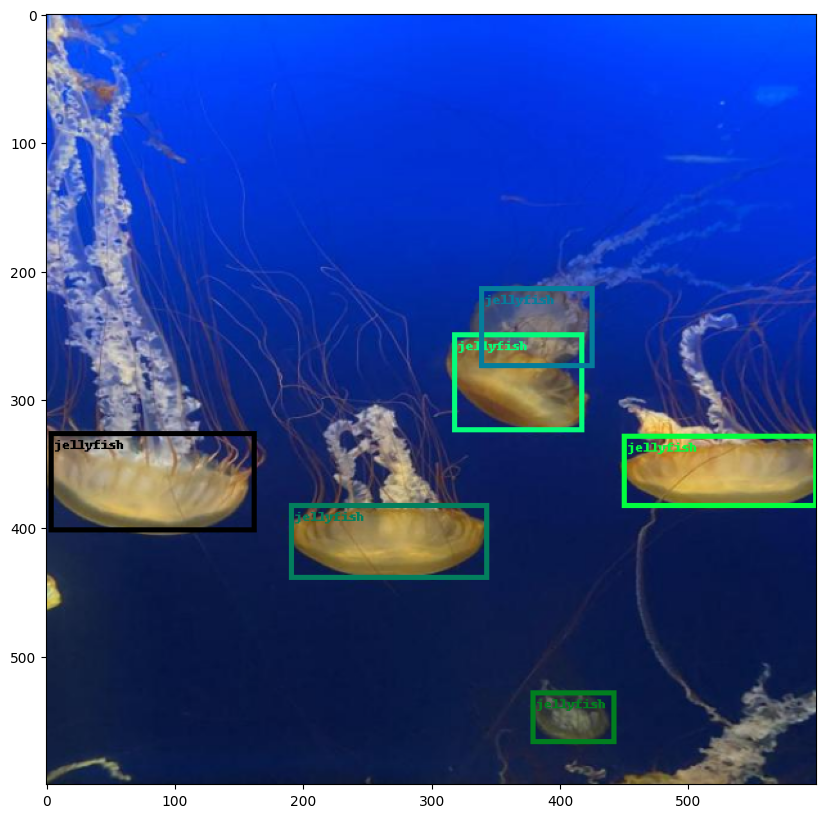

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))